In [0]:
import torch 
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import numpy as np 

In [0]:
dim = 28
def mnist_data():
    transform=transforms.Compose([
                    transforms.Grayscale(num_output_channels=1),
                    transforms.ToTensor()
                ])

    data = datasets.MNIST(root='./dataset', train=True,
                                        download=True, transform=transform)
    
    return data

In [0]:
data = mnist_data()

data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

0it [00:00, ?it/s]

9920512it [00:08, 1213327.42it/s]                             


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 48857.11it/s]                           
0it [00:00, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 917386.47it/s]                            
0it [00:00, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 18516.62it/s]            

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Models classes

In [0]:
class DiscriminatorNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = dim*dim
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
            

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), dim*dim)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, dim, dim)

In [0]:
class GeneratorNet(torch.nn.Module):
    
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = dim*dim
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [0]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [0]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

d_steps = 1 
num_epochs = 300

In [0]:
def real_data_target(size):
    
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

# Training models separately

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    optimizer.step()
    
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)
print(test_noise.view(1,-1))

tensor([[-2.0229, -2.1873, -0.3806,  ..., -1.1397, -0.5320,  0.4462]],
       device='cuda:0')


# Training GAN

Epoch: [0/300], Batch Num: [0/600]
Discriminator Loss: 0.3388, Generator Loss: 3.5297
D(x): 0.8942, D(G(z)): 0.1086
Epoch: [0/300], Batch Num: [100/600]
Discriminator Loss: 0.2494, Generator Loss: 3.7953
D(x): 0.9227, D(G(z)): 0.0861
Epoch: [0/300], Batch Num: [200/600]
Discriminator Loss: 0.3698, Generator Loss: 2.8874
D(x): 0.9119, D(G(z)): 0.1331
Epoch: [0/300], Batch Num: [300/600]
Discriminator Loss: 0.3803, Generator Loss: 3.3355
D(x): 0.8752, D(G(z)): 0.0932
Epoch: [0/300], Batch Num: [400/600]
Discriminator Loss: 0.3695, Generator Loss: 3.1511
D(x): 0.8948, D(G(z)): 0.1061
Epoch: [0/300], Batch Num: [500/600]
Discriminator Loss: 0.3851, Generator Loss: 3.4730
D(x): 0.8760, D(G(z)): 0.0966


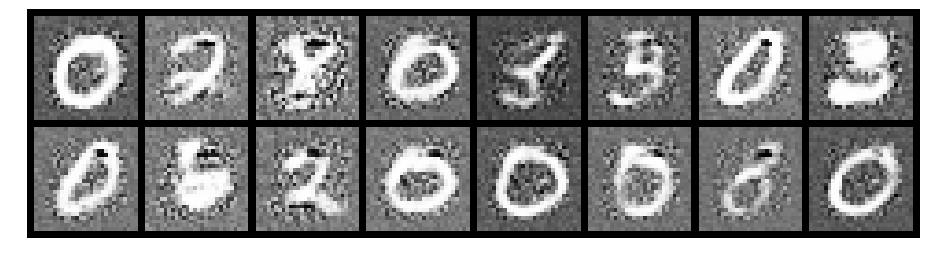

Epoch: [1/300], Batch Num: [0/600]
Discriminator Loss: 0.2896, Generator Loss: 3.8395
D(x): 0.9244, D(G(z)): 0.1101
Epoch: [1/300], Batch Num: [100/600]
Discriminator Loss: 0.2935, Generator Loss: 3.6576
D(x): 0.9039, D(G(z)): 0.0949
Epoch: [1/300], Batch Num: [200/600]
Discriminator Loss: 0.1839, Generator Loss: 3.0351
D(x): 0.9475, D(G(z)): 0.0958
Epoch: [1/300], Batch Num: [300/600]
Discriminator Loss: 0.3519, Generator Loss: 3.4887
D(x): 0.8899, D(G(z)): 0.0999
Epoch: [1/300], Batch Num: [400/600]
Discriminator Loss: 0.3771, Generator Loss: 3.7052
D(x): 0.9179, D(G(z)): 0.1153
Epoch: [1/300], Batch Num: [500/600]
Discriminator Loss: 0.3727, Generator Loss: 3.1357
D(x): 0.8855, D(G(z)): 0.1028


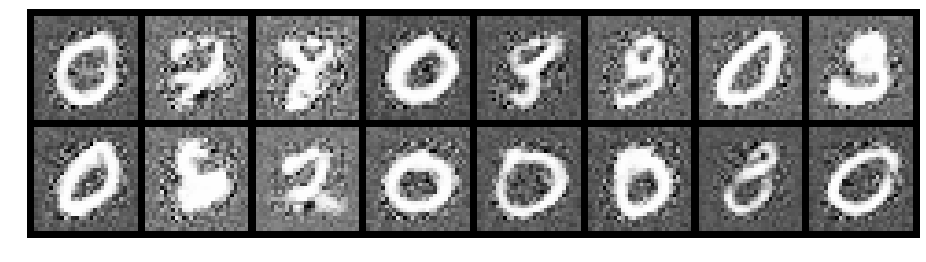

Epoch: [2/300], Batch Num: [0/600]
Discriminator Loss: 0.3276, Generator Loss: 3.7945
D(x): 0.9194, D(G(z)): 0.1057
Epoch: [2/300], Batch Num: [100/600]
Discriminator Loss: 0.3516, Generator Loss: 3.1680
D(x): 0.9002, D(G(z)): 0.1179
Epoch: [2/300], Batch Num: [200/600]
Discriminator Loss: 0.3505, Generator Loss: 3.3368
D(x): 0.9067, D(G(z)): 0.1229
Epoch: [2/300], Batch Num: [300/600]
Discriminator Loss: 0.3222, Generator Loss: 3.2182
D(x): 0.9084, D(G(z)): 0.1244
Epoch: [2/300], Batch Num: [400/600]
Discriminator Loss: 0.4825, Generator Loss: 3.6931
D(x): 0.8623, D(G(z)): 0.1239
Epoch: [2/300], Batch Num: [500/600]
Discriminator Loss: 0.2262, Generator Loss: 3.3326
D(x): 0.9320, D(G(z)): 0.0971


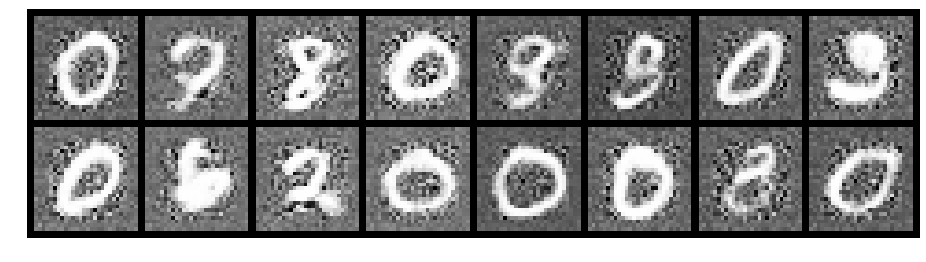

Epoch: [3/300], Batch Num: [0/600]
Discriminator Loss: 0.4076, Generator Loss: 3.0773
D(x): 0.8695, D(G(z)): 0.1117
Epoch: [3/300], Batch Num: [100/600]
Discriminator Loss: 0.5126, Generator Loss: 3.3551
D(x): 0.8746, D(G(z)): 0.1262
Epoch: [3/300], Batch Num: [200/600]
Discriminator Loss: 0.2952, Generator Loss: 3.3730
D(x): 0.9089, D(G(z)): 0.1106
Epoch: [3/300], Batch Num: [300/600]
Discriminator Loss: 0.2396, Generator Loss: 3.5397
D(x): 0.9432, D(G(z)): 0.1012
Epoch: [3/300], Batch Num: [400/600]
Discriminator Loss: 0.3087, Generator Loss: 3.4281
D(x): 0.8992, D(G(z)): 0.0895
Epoch: [3/300], Batch Num: [500/600]
Discriminator Loss: 0.2948, Generator Loss: 3.6452
D(x): 0.9103, D(G(z)): 0.0837


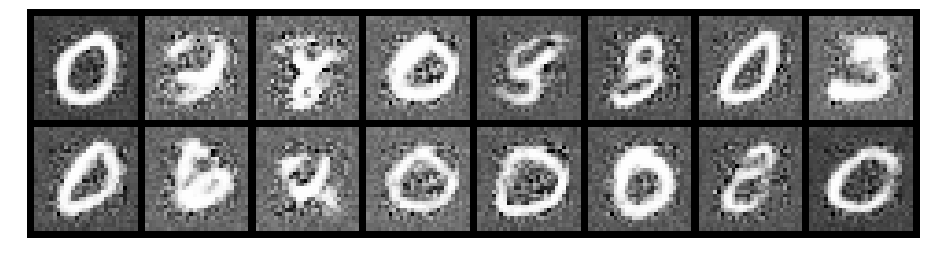

Epoch: [4/300], Batch Num: [0/600]
Discriminator Loss: 0.4114, Generator Loss: 2.8418
D(x): 0.8552, D(G(z)): 0.1080
Epoch: [4/300], Batch Num: [100/600]
Discriminator Loss: 0.4563, Generator Loss: 2.7268
D(x): 0.8734, D(G(z)): 0.1207
Epoch: [4/300], Batch Num: [200/600]
Discriminator Loss: 0.3828, Generator Loss: 2.9121
D(x): 0.8833, D(G(z)): 0.1385
Epoch: [4/300], Batch Num: [300/600]
Discriminator Loss: 0.3086, Generator Loss: 3.2916
D(x): 0.8930, D(G(z)): 0.1075
Epoch: [4/300], Batch Num: [400/600]
Discriminator Loss: 0.4933, Generator Loss: 3.6406
D(x): 0.8871, D(G(z)): 0.1189
Epoch: [4/300], Batch Num: [500/600]
Discriminator Loss: 0.4674, Generator Loss: 3.0140
D(x): 0.8578, D(G(z)): 0.1322


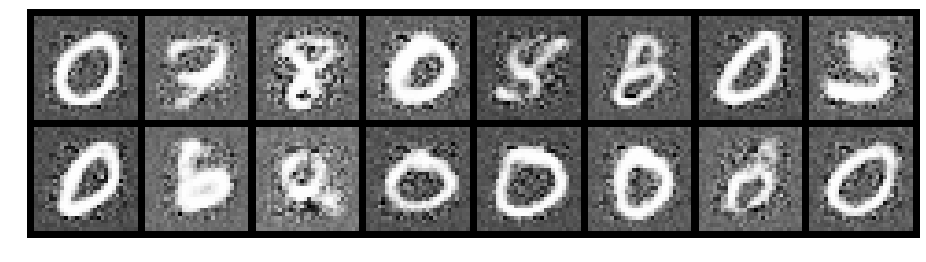

Epoch: [5/300], Batch Num: [0/600]
Discriminator Loss: 0.2870, Generator Loss: 3.7807
D(x): 0.8945, D(G(z)): 0.0810
Epoch: [5/300], Batch Num: [100/600]
Discriminator Loss: 0.3288, Generator Loss: 3.0989
D(x): 0.9193, D(G(z)): 0.1344
Epoch: [5/300], Batch Num: [200/600]
Discriminator Loss: 0.3697, Generator Loss: 3.1119
D(x): 0.8868, D(G(z)): 0.1191
Epoch: [5/300], Batch Num: [300/600]
Discriminator Loss: 0.3252, Generator Loss: 3.3292
D(x): 0.8882, D(G(z)): 0.0859
Epoch: [5/300], Batch Num: [400/600]
Discriminator Loss: 0.5465, Generator Loss: 3.6512
D(x): 0.8502, D(G(z)): 0.1233
Epoch: [5/300], Batch Num: [500/600]
Discriminator Loss: 0.2467, Generator Loss: 3.5175
D(x): 0.9151, D(G(z)): 0.0830


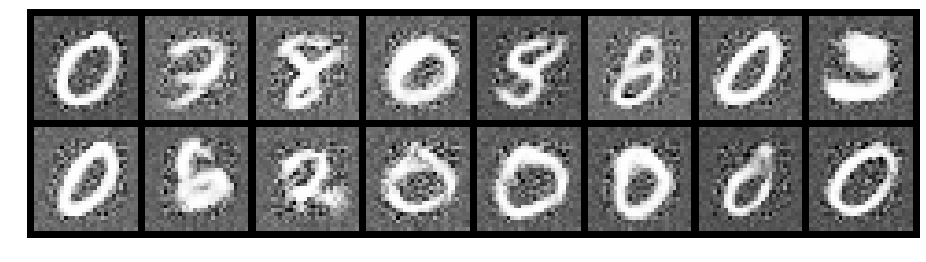

Epoch: [6/300], Batch Num: [0/600]
Discriminator Loss: 0.4460, Generator Loss: 3.1029
D(x): 0.8816, D(G(z)): 0.1365
Epoch: [6/300], Batch Num: [100/600]
Discriminator Loss: 0.2543, Generator Loss: 3.5998
D(x): 0.9225, D(G(z)): 0.0835
Epoch: [6/300], Batch Num: [200/600]
Discriminator Loss: 0.3312, Generator Loss: 3.2663
D(x): 0.8820, D(G(z)): 0.0850
Epoch: [6/300], Batch Num: [300/600]
Discriminator Loss: 0.2370, Generator Loss: 2.9546
D(x): 0.9205, D(G(z)): 0.0805
Epoch: [6/300], Batch Num: [400/600]
Discriminator Loss: 0.3759, Generator Loss: 3.1760
D(x): 0.8986, D(G(z)): 0.1227
Epoch: [6/300], Batch Num: [500/600]
Discriminator Loss: 0.3107, Generator Loss: 3.5163
D(x): 0.9042, D(G(z)): 0.0596


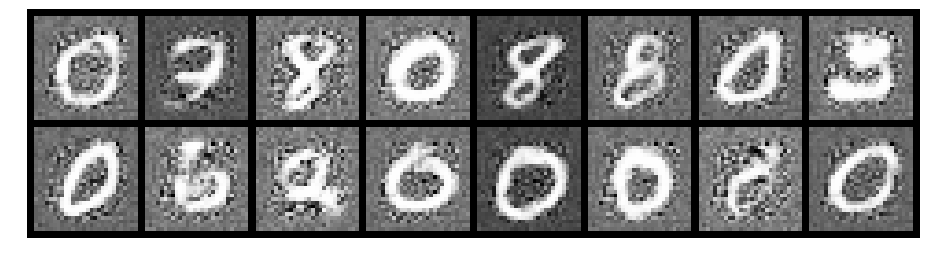

Epoch: [7/300], Batch Num: [0/600]
Discriminator Loss: 0.3669, Generator Loss: 3.0526
D(x): 0.8953, D(G(z)): 0.1127
Epoch: [7/300], Batch Num: [100/600]
Discriminator Loss: 0.3949, Generator Loss: 3.1248
D(x): 0.8924, D(G(z)): 0.1385
Epoch: [7/300], Batch Num: [200/600]
Discriminator Loss: 0.2839, Generator Loss: 3.5830
D(x): 0.9216, D(G(z)): 0.0993
Epoch: [7/300], Batch Num: [300/600]
Discriminator Loss: 0.3026, Generator Loss: 2.7718
D(x): 0.9497, D(G(z)): 0.1528
Epoch: [7/300], Batch Num: [400/600]
Discriminator Loss: 0.3844, Generator Loss: 3.4601
D(x): 0.8740, D(G(z)): 0.0703
Epoch: [7/300], Batch Num: [500/600]
Discriminator Loss: 0.5363, Generator Loss: 3.0812
D(x): 0.8515, D(G(z)): 0.1476


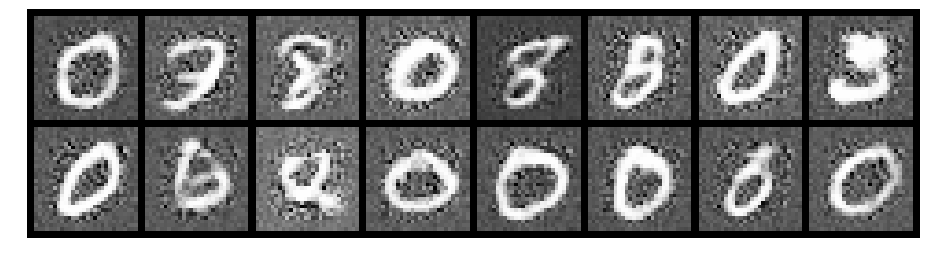

Epoch: [8/300], Batch Num: [0/600]
Discriminator Loss: 0.4022, Generator Loss: 3.5520
D(x): 0.8948, D(G(z)): 0.1284
Epoch: [8/300], Batch Num: [100/600]
Discriminator Loss: 0.3707, Generator Loss: 3.6186
D(x): 0.8901, D(G(z)): 0.1191
Epoch: [8/300], Batch Num: [200/600]
Discriminator Loss: 0.3341, Generator Loss: 3.4470
D(x): 0.8640, D(G(z)): 0.0721
Epoch: [8/300], Batch Num: [300/600]
Discriminator Loss: 0.2392, Generator Loss: 3.5290
D(x): 0.9150, D(G(z)): 0.0758
Epoch: [8/300], Batch Num: [400/600]
Discriminator Loss: 0.3630, Generator Loss: 3.5249
D(x): 0.8795, D(G(z)): 0.0958
Epoch: [8/300], Batch Num: [500/600]
Discriminator Loss: 0.3030, Generator Loss: 3.2044
D(x): 0.8863, D(G(z)): 0.0981


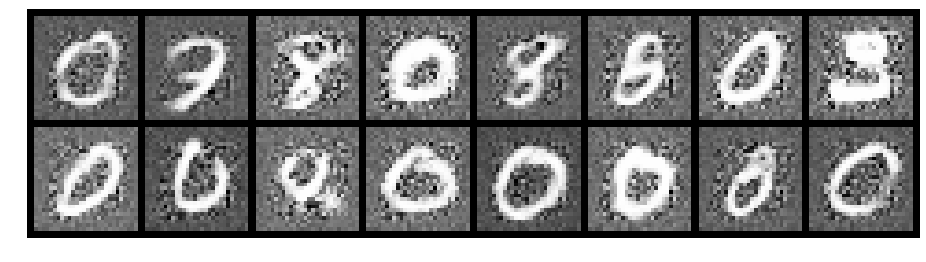

Epoch: [9/300], Batch Num: [0/600]
Discriminator Loss: 0.2434, Generator Loss: 3.4993
D(x): 0.9204, D(G(z)): 0.0786
Epoch: [9/300], Batch Num: [100/600]
Discriminator Loss: 0.3820, Generator Loss: 3.0282
D(x): 0.9112, D(G(z)): 0.1293
Epoch: [9/300], Batch Num: [200/600]
Discriminator Loss: 0.6218, Generator Loss: 2.9327
D(x): 0.8515, D(G(z)): 0.1724
Epoch: [9/300], Batch Num: [300/600]
Discriminator Loss: 0.3855, Generator Loss: 3.2535
D(x): 0.8944, D(G(z)): 0.1262
Epoch: [9/300], Batch Num: [400/600]
Discriminator Loss: 0.3639, Generator Loss: 3.1425
D(x): 0.8892, D(G(z)): 0.1197
Epoch: [9/300], Batch Num: [500/600]
Discriminator Loss: 0.3992, Generator Loss: 4.0048
D(x): 0.8825, D(G(z)): 0.0933


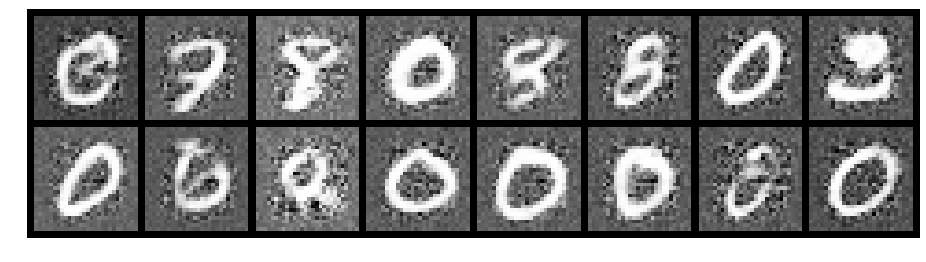

Epoch: [10/300], Batch Num: [0/600]
Discriminator Loss: 0.4310, Generator Loss: 3.3000
D(x): 0.8920, D(G(z)): 0.1261
Epoch: [10/300], Batch Num: [100/600]
Discriminator Loss: 0.4925, Generator Loss: 3.1972
D(x): 0.8733, D(G(z)): 0.1389
Epoch: [10/300], Batch Num: [200/600]
Discriminator Loss: 0.4624, Generator Loss: 3.3255
D(x): 0.9245, D(G(z)): 0.1794
Epoch: [10/300], Batch Num: [300/600]
Discriminator Loss: 0.3763, Generator Loss: 3.0128
D(x): 0.8908, D(G(z)): 0.1381
Epoch: [10/300], Batch Num: [400/600]
Discriminator Loss: 0.3600, Generator Loss: 3.6993
D(x): 0.8677, D(G(z)): 0.0824
Epoch: [10/300], Batch Num: [500/600]
Discriminator Loss: 0.3343, Generator Loss: 3.5693
D(x): 0.8748, D(G(z)): 0.0953


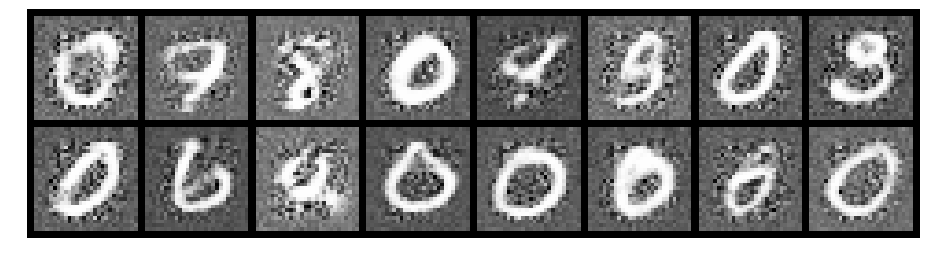

Epoch: [11/300], Batch Num: [0/600]
Discriminator Loss: 0.6427, Generator Loss: 3.0209
D(x): 0.8619, D(G(z)): 0.1840
Epoch: [11/300], Batch Num: [100/600]
Discriminator Loss: 0.3921, Generator Loss: 3.2058
D(x): 0.8924, D(G(z)): 0.1310
Epoch: [11/300], Batch Num: [200/600]
Discriminator Loss: 0.4743, Generator Loss: 3.4274
D(x): 0.8745, D(G(z)): 0.1404
Epoch: [11/300], Batch Num: [300/600]
Discriminator Loss: 0.3208, Generator Loss: 3.3183
D(x): 0.9112, D(G(z)): 0.1097
Epoch: [11/300], Batch Num: [400/600]
Discriminator Loss: 0.4317, Generator Loss: 3.3303
D(x): 0.8736, D(G(z)): 0.1204
Epoch: [11/300], Batch Num: [500/600]
Discriminator Loss: 0.2405, Generator Loss: 3.2414
D(x): 0.9251, D(G(z)): 0.0760


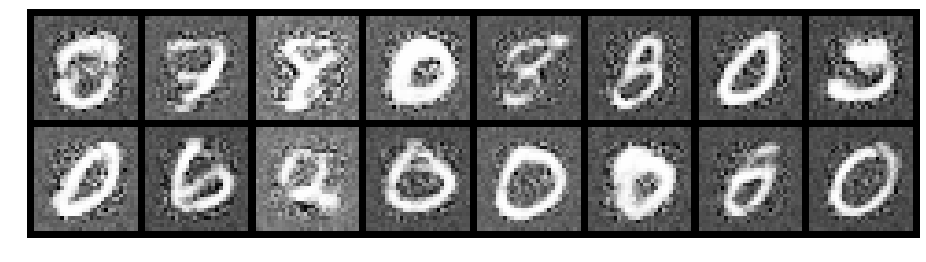

Epoch: [12/300], Batch Num: [0/600]
Discriminator Loss: 0.2898, Generator Loss: 3.1184
D(x): 0.9322, D(G(z)): 0.1245
Epoch: [12/300], Batch Num: [100/600]
Discriminator Loss: 0.3985, Generator Loss: 3.7200
D(x): 0.8690, D(G(z)): 0.0784
Epoch: [12/300], Batch Num: [200/600]
Discriminator Loss: 0.2602, Generator Loss: 3.3954
D(x): 0.9249, D(G(z)): 0.1075
Epoch: [12/300], Batch Num: [300/600]
Discriminator Loss: 0.4715, Generator Loss: 2.6516
D(x): 0.8957, D(G(z)): 0.1648
Epoch: [12/300], Batch Num: [400/600]
Discriminator Loss: 0.1756, Generator Loss: 3.1342
D(x): 0.9359, D(G(z)): 0.0722
Epoch: [12/300], Batch Num: [500/600]
Discriminator Loss: 0.6643, Generator Loss: 3.4176
D(x): 0.8502, D(G(z)): 0.1545


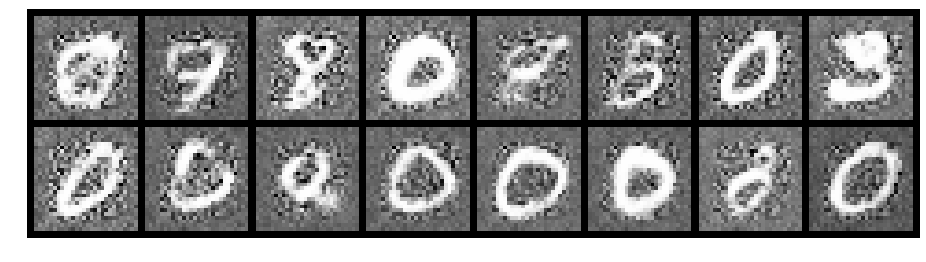

Epoch: [13/300], Batch Num: [0/600]
Discriminator Loss: 0.3747, Generator Loss: 3.2673
D(x): 0.8771, D(G(z)): 0.0981
Epoch: [13/300], Batch Num: [100/600]
Discriminator Loss: 0.3017, Generator Loss: 3.3669
D(x): 0.9038, D(G(z)): 0.1175
Epoch: [13/300], Batch Num: [200/600]
Discriminator Loss: 0.3673, Generator Loss: 3.0365
D(x): 0.9429, D(G(z)): 0.1597
Epoch: [13/300], Batch Num: [300/600]
Discriminator Loss: 0.5001, Generator Loss: 3.2874
D(x): 0.8750, D(G(z)): 0.1347
Epoch: [13/300], Batch Num: [400/600]
Discriminator Loss: 0.4859, Generator Loss: 3.0239
D(x): 0.8766, D(G(z)): 0.1221
Epoch: [13/300], Batch Num: [500/600]
Discriminator Loss: 0.4407, Generator Loss: 3.0794
D(x): 0.8710, D(G(z)): 0.1264


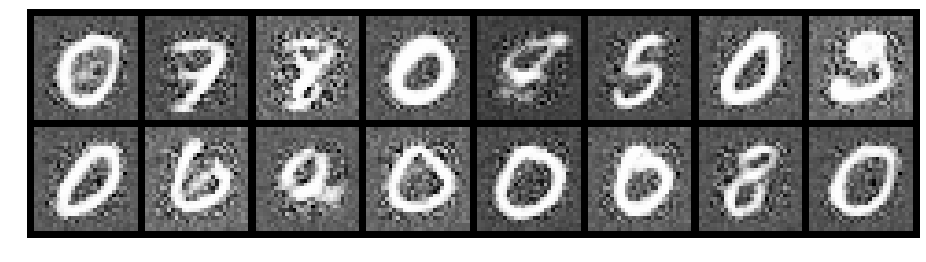

Epoch: [14/300], Batch Num: [0/600]
Discriminator Loss: 0.3650, Generator Loss: 3.3603
D(x): 0.9129, D(G(z)): 0.1109
Epoch: [14/300], Batch Num: [100/600]
Discriminator Loss: 0.3936, Generator Loss: 3.2502
D(x): 0.9018, D(G(z)): 0.1286
Epoch: [14/300], Batch Num: [200/600]
Discriminator Loss: 0.3536, Generator Loss: 3.5139
D(x): 0.8617, D(G(z)): 0.0885
Epoch: [14/300], Batch Num: [300/600]
Discriminator Loss: 0.2732, Generator Loss: 3.6760
D(x): 0.9028, D(G(z)): 0.0686
Epoch: [14/300], Batch Num: [400/600]
Discriminator Loss: 0.4610, Generator Loss: 3.4687
D(x): 0.8946, D(G(z)): 0.1431
Epoch: [14/300], Batch Num: [500/600]
Discriminator Loss: 0.3543, Generator Loss: 2.7908
D(x): 0.9065, D(G(z)): 0.1258


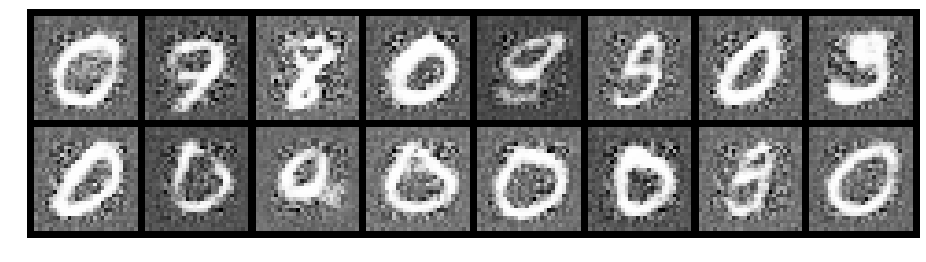

Epoch: [15/300], Batch Num: [0/600]
Discriminator Loss: 0.2656, Generator Loss: 3.4931
D(x): 0.9202, D(G(z)): 0.1058
Epoch: [15/300], Batch Num: [100/600]
Discriminator Loss: 0.3780, Generator Loss: 3.8537
D(x): 0.8905, D(G(z)): 0.1114
Epoch: [15/300], Batch Num: [200/600]
Discriminator Loss: 0.4573, Generator Loss: 3.6011
D(x): 0.8833, D(G(z)): 0.1439
Epoch: [15/300], Batch Num: [300/600]
Discriminator Loss: 0.3933, Generator Loss: 3.2648
D(x): 0.8981, D(G(z)): 0.1477
Epoch: [15/300], Batch Num: [400/600]
Discriminator Loss: 0.2539, Generator Loss: 3.5885
D(x): 0.9177, D(G(z)): 0.0906
Epoch: [15/300], Batch Num: [500/600]
Discriminator Loss: 0.4039, Generator Loss: 3.2288
D(x): 0.8793, D(G(z)): 0.1156


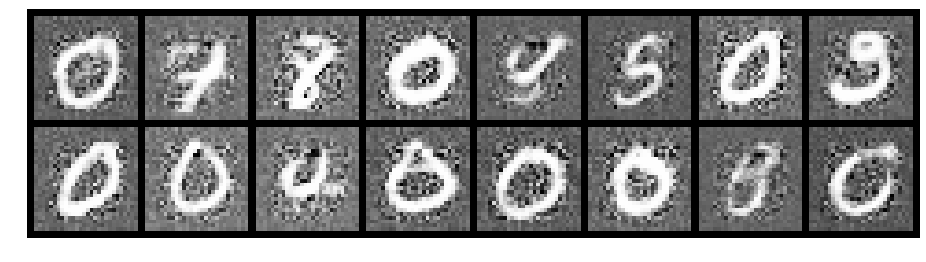

Epoch: [16/300], Batch Num: [0/600]
Discriminator Loss: 0.3722, Generator Loss: 3.4157
D(x): 0.9113, D(G(z)): 0.1286
Epoch: [16/300], Batch Num: [100/600]
Discriminator Loss: 0.4302, Generator Loss: 3.2918
D(x): 0.9050, D(G(z)): 0.1317
Epoch: [16/300], Batch Num: [200/600]
Discriminator Loss: 0.3492, Generator Loss: 3.6440
D(x): 0.8744, D(G(z)): 0.0702
Epoch: [16/300], Batch Num: [300/600]
Discriminator Loss: 0.3114, Generator Loss: 3.3715
D(x): 0.8800, D(G(z)): 0.0721
Epoch: [16/300], Batch Num: [400/600]
Discriminator Loss: 0.3053, Generator Loss: 3.0589
D(x): 0.9135, D(G(z)): 0.1110
Epoch: [16/300], Batch Num: [500/600]
Discriminator Loss: 0.3610, Generator Loss: 3.2396
D(x): 0.8702, D(G(z)): 0.1007


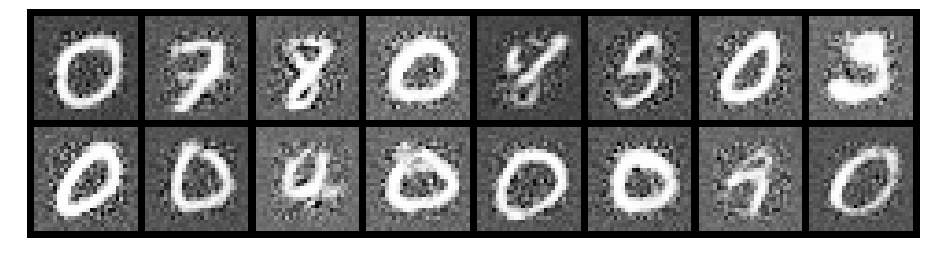

Epoch: [17/300], Batch Num: [0/600]
Discriminator Loss: 0.4266, Generator Loss: 3.4126
D(x): 0.8733, D(G(z)): 0.1014
Epoch: [17/300], Batch Num: [100/600]
Discriminator Loss: 0.2699, Generator Loss: 3.3983
D(x): 0.9204, D(G(z)): 0.1029
Epoch: [17/300], Batch Num: [200/600]
Discriminator Loss: 0.3818, Generator Loss: 3.0535
D(x): 0.9063, D(G(z)): 0.1219
Epoch: [17/300], Batch Num: [300/600]
Discriminator Loss: 0.2966, Generator Loss: 4.3685
D(x): 0.8938, D(G(z)): 0.0596
Epoch: [17/300], Batch Num: [400/600]
Discriminator Loss: 0.2928, Generator Loss: 2.9798
D(x): 0.9047, D(G(z)): 0.1116
Epoch: [17/300], Batch Num: [500/600]
Discriminator Loss: 0.4071, Generator Loss: 3.2097
D(x): 0.8672, D(G(z)): 0.0954


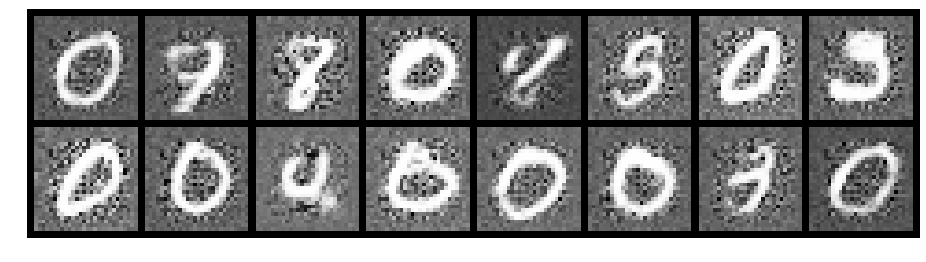

Epoch: [18/300], Batch Num: [0/600]
Discriminator Loss: 0.3121, Generator Loss: 3.3867
D(x): 0.9457, D(G(z)): 0.1366
Epoch: [18/300], Batch Num: [100/600]
Discriminator Loss: 0.3965, Generator Loss: 3.3508
D(x): 0.8817, D(G(z)): 0.1270
Epoch: [18/300], Batch Num: [200/600]
Discriminator Loss: 0.2444, Generator Loss: 3.1709
D(x): 0.9156, D(G(z)): 0.0913
Epoch: [18/300], Batch Num: [300/600]
Discriminator Loss: 0.2963, Generator Loss: 3.1990
D(x): 0.8929, D(G(z)): 0.1024
Epoch: [18/300], Batch Num: [400/600]
Discriminator Loss: 0.4734, Generator Loss: 3.1343
D(x): 0.8498, D(G(z)): 0.0963
Epoch: [18/300], Batch Num: [500/600]
Discriminator Loss: 0.3322, Generator Loss: 3.7716
D(x): 0.9003, D(G(z)): 0.1020


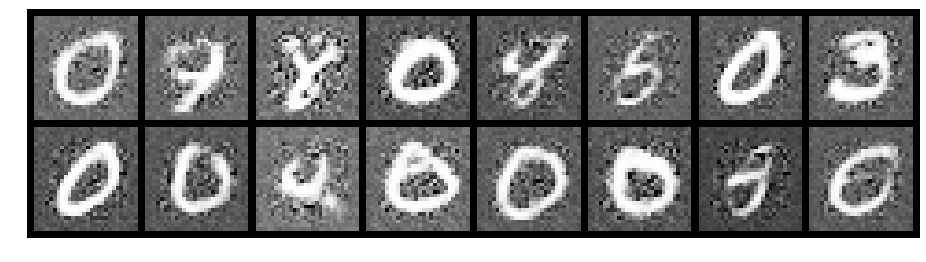

Epoch: [19/300], Batch Num: [0/600]
Discriminator Loss: 0.5061, Generator Loss: 3.3738
D(x): 0.8564, D(G(z)): 0.1530
Epoch: [19/300], Batch Num: [100/600]
Discriminator Loss: 0.5288, Generator Loss: 3.2085
D(x): 0.8714, D(G(z)): 0.1523
Epoch: [19/300], Batch Num: [200/600]
Discriminator Loss: 0.3353, Generator Loss: 3.3685
D(x): 0.9148, D(G(z)): 0.1151
Epoch: [19/300], Batch Num: [300/600]
Discriminator Loss: 0.3952, Generator Loss: 3.9237
D(x): 0.8522, D(G(z)): 0.0720
Epoch: [19/300], Batch Num: [400/600]
Discriminator Loss: 0.3805, Generator Loss: 2.9736
D(x): 0.8886, D(G(z)): 0.1244
Epoch: [19/300], Batch Num: [500/600]
Discriminator Loss: 0.4125, Generator Loss: 3.5624
D(x): 0.8670, D(G(z)): 0.1289


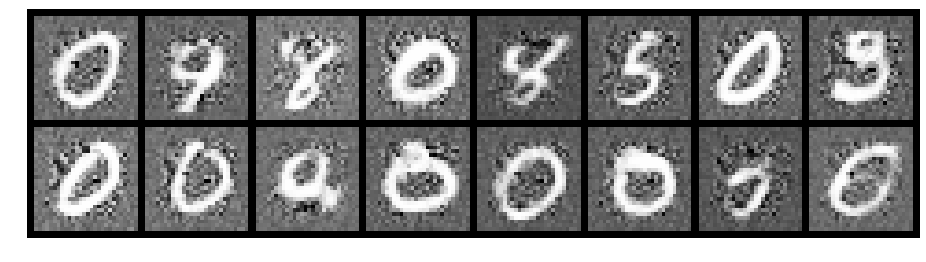

Epoch: [20/300], Batch Num: [0/600]
Discriminator Loss: 0.3387, Generator Loss: 2.9731
D(x): 0.8852, D(G(z)): 0.0950
Epoch: [20/300], Batch Num: [100/600]
Discriminator Loss: 0.3679, Generator Loss: 3.1370
D(x): 0.8624, D(G(z)): 0.0859
Epoch: [20/300], Batch Num: [200/600]
Discriminator Loss: 0.3331, Generator Loss: 3.3518
D(x): 0.8959, D(G(z)): 0.1048
Epoch: [20/300], Batch Num: [300/600]
Discriminator Loss: 0.3253, Generator Loss: 3.2941
D(x): 0.9105, D(G(z)): 0.1148
Epoch: [20/300], Batch Num: [400/600]
Discriminator Loss: 0.4278, Generator Loss: 2.9165
D(x): 0.8835, D(G(z)): 0.1410
Epoch: [20/300], Batch Num: [500/600]
Discriminator Loss: 0.4466, Generator Loss: 3.0760
D(x): 0.8931, D(G(z)): 0.1226


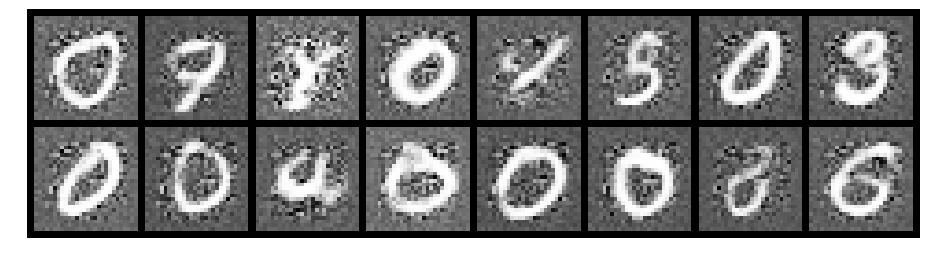

Epoch: [21/300], Batch Num: [0/600]
Discriminator Loss: 0.3911, Generator Loss: 3.4366
D(x): 0.8596, D(G(z)): 0.0863


KeyboardInterrupt: ignored

In [62]:
!pip install tensorboardx
import matplotlib.pyplot as plt 
from utils import Logger
import numpy as np
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    n_batch = 0    
    for real_batch, _ in data_loader:
        
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        
        fake_data = generator(noise(real_data.size(0))).detach()
        
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        

        if (n_batch) % 100 == 0:
            
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        
        logger.save_models(generator, discriminator, epoch)
        
        n_batch += 1
    
    with torch.no_grad():
        test_images = vectors_to_images(generator(test_noise)).data.cpu()
        logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);

# Save trained parameters

In [2]:
!mkdir model

torch.save(generator.state_dict(), 'model/gen.model')
torch.save(discriminator.state_dict(), 'model/disc.model')